In [2]:
import warnings
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import assemble
from qiskit import pulse
from qiskit.pulse import pulse_lib
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

# Pick your favorite (not busy) Backend 

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-internal',group='dev-qiskit')
backend = provider.get_backend('ibmq_johannesburg')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"
backend_defaults = backend.defaults()

dt = backend_config.dt
print(f"Sampling time: {dt} ns")    # The configuration returns dt in seconds

Sampling time: 3.5555555555555554e-09 ns


In [4]:
cmd_def = pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)

# Choosing Qubit & Extract Default Gates
Part of OpenPulse is that you can choose to extract the already made/calibrated waveforms. Below we will extract the X gate and the default measurement gate.  In this notebook we will later show how one can tune up the readout pulse itself

In [5]:
qubit = 0
x_gate = cmd_def.get('u3', [qubit], P0=np.pi, P1=0.0, P2=np.pi)
measure_gate = cmd_def.get('measure', qubits=backend_config.meas_map[qubit])

# Establishing Various channels
Here we are establishing the various channels to be used.  Note: Measure channel refers to channel that send readout pulses whereas acquire channel refers to the actual download of the readout pulse. All acquire pulses must happen at the same time and no pulses can occur after (currently).

In [6]:
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

# Set common measurement time
Readout can sometimes be sensitive to phase and timing.  For this reason it's useful to set a common readout time

In [7]:
measure_time = 40

# Qubit Spectropscopy
So, a prototypical qubit measurement is to use two-tone spectroscopy and sweep the "pump" tone to find the qubit frequency. First we will start with the default backends and create an appropriate schedule

In [8]:
GHz = 1.0e9
MHz = 1.0e6

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 2 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min, 
                            frequency_max, 
                            frequency_step_Hz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.664850261900243 GHz.
The sweep will go from 4.644850261900243 GHz to 4.684850261900243 GHz in steps of 2.0 MHz.


In [9]:
schedule = pulse.Schedule(name='Qubit Frequency sweep')
schedule += x_gate
schedule += measure_gate <<measure_time

schedule_frequencies = [{drive_chan: freq} for freq in frequencies_GHz]

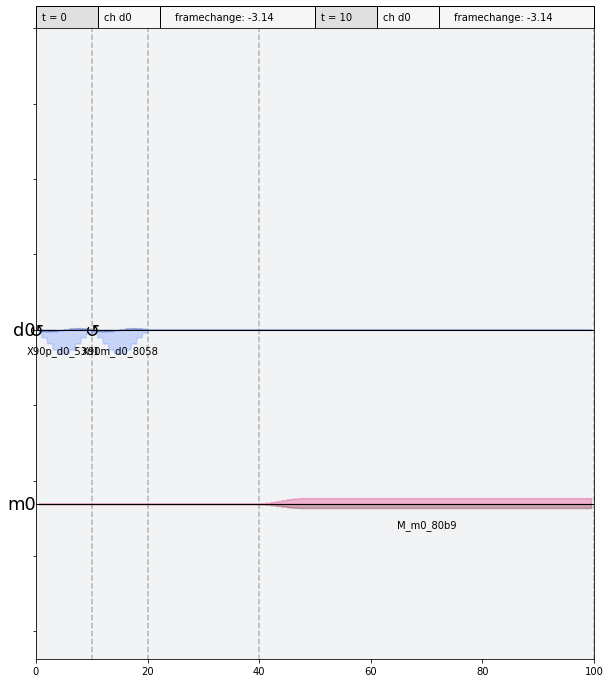

In [10]:
schedule.draw(plot_range=[0,100],channels_to_plot=[drive_chan, meas_chan], label=True, scaling=1.0)

In [11]:
num_shots_per_frequency = 1024
ground_resonator_freq_sweep = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)


job = backend.run(ground_resonator_freq_sweep)
print (job.job_id())

5e583da0c8c7bc0018166adc


In [12]:
# qubit_spec_codes = ["5e308314edc73f0018347bc9"] #codes for johannesburg backend
qubit_spec_codes = ["5e3084545b1d1100124c0fff"] #codes for johannesburg backend
qubit=0
all_vals = []
for i in range(len(qubit_spec_codes)):
    sweep_values = []
    job = backend.retrieve_job(qubit_spec_codes[i])
    frequency_sweep_results = job.result(timeout=120)
    for j in range(len(frequency_sweep_results.results)):
        res = frequency_sweep_results.get_memory(j)
        sweep_values.append(res[qubit])
    all_vals.append(sweep_values)
    



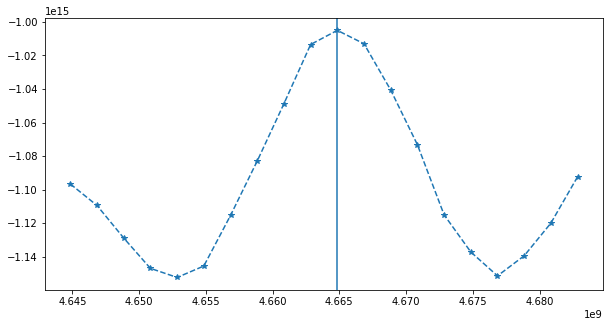

In [13]:
plt.figure(figsize=(10,5))
for i in range(len(qubit_spec_codes)):
    plt.plot(frequencies_GHz, all_vals[i],"*--")
plt.axvline(center_frequency_Hz)
plt.show()

# Let's try and find the Second excited state |2>

In [14]:
anharmonicity = 312.0e6

In [15]:
GHz = 1.0e9
MHz = 1.0e6

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit] - anharmonicity/2.0        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 10 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 0.5 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min, 
                            frequency_max, 
                            frequency_step_Hz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.508850261900243 GHz.
The sweep will go from 4.503850261900243 GHz to 4.5138502619002425 GHz in steps of 0.5 MHz.


In [16]:
schedule = pulse.Schedule(name='Qubit Frequency sweep')
schedule += x_gate
schedule += measure_gate <<measure_time

schedule_frequencies = [{drive_chan: freq} for freq in frequencies_GHz]

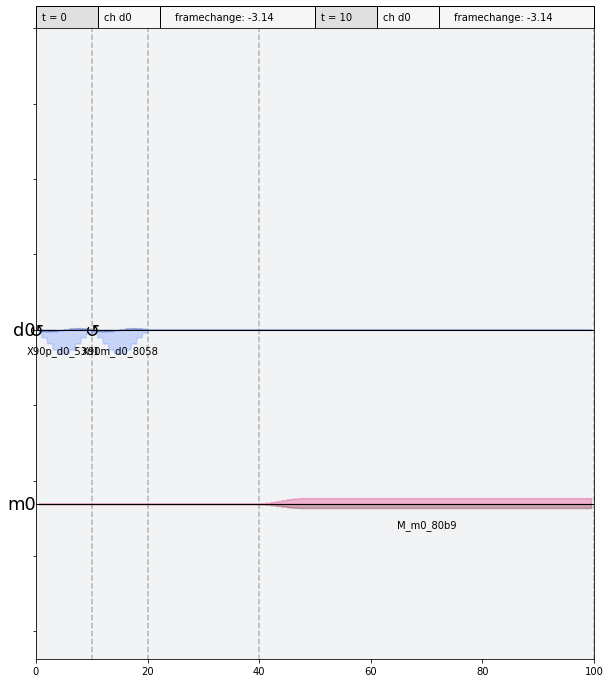

In [17]:
schedule.draw(plot_range=[0,100],channels_to_plot=[drive_chan, meas_chan], label=True, scaling=1.0)

In [18]:
num_shots_per_frequency = 8192
ground_resonator_freq_sweep = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)


job = backend.run(ground_resonator_freq_sweep)
print (job.job_id())

5e583da45e6e5300198b7371


In [19]:
qubit_spec_codes = ["5e30e0845b1d1100124c11ea"] #codes for johannesburg backend
qubit=0
all_vals = []
for i in range(len(qubit_spec_codes)):
    sweep_values = []
    job = backend.retrieve_job(qubit_spec_codes[i])
    frequency_sweep_results = job.result(timeout=120)
    for j in range(len(frequency_sweep_results.results)):
        res = frequency_sweep_results.get_memory(j)
        sweep_values.append(res[qubit])
    all_vals.append(sweep_values)
    



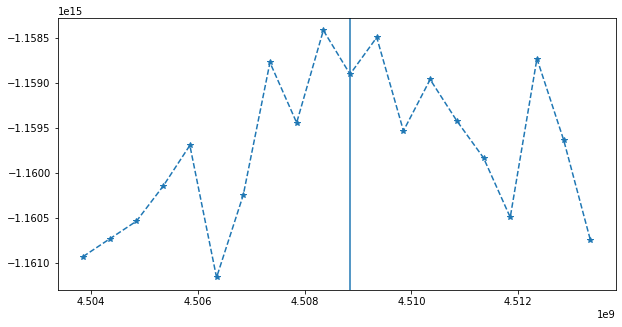

In [20]:
plt.figure(figsize=(10,5))
for i in range(len(qubit_spec_codes)):
    plt.plot(frequencies_GHz, all_vals[i],"*--")
plt.axvline(center_frequency_Hz)

plt.show()

# Increase Drive Power

In [21]:
schedule = pulse.Schedule(name='Qubit Frequency sweep')

# drive pulse parameters
drive_power = 0.4
drive_samples = 128
drive_sigma = 16

# creating drive pulse
drive_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_power,
                                 sigma=drive_sigma, name='mydrivepulse')
drive_pulse_qubit = drive_pulse(drive_chan)

schedule += drive_pulse_qubit
schedule += measure_gate <<schedule.duration

schedule_frequencies = [{drive_chan: freq} for freq in frequencies_GHz]

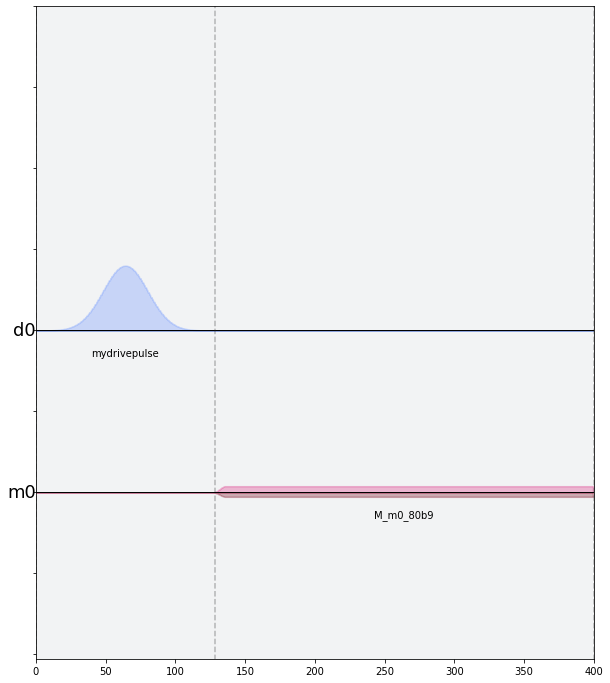

In [22]:
schedule.draw(plot_range=[0,400],channels_to_plot=[drive_chan, meas_chan], label=True, scaling=1.0)

In [23]:
num_shots_per_frequency = 8192
ground_resonator_freq_sweep = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)


job = backend.run(ground_resonator_freq_sweep)
print (job.job_id())

5e583da85e6e5300198b7373


In [24]:
qubit_spec_codes = ["5e30e0a69706bd001221a2c2"] 
qubit=0
all_vals = []
for i in range(len(qubit_spec_codes)):
    sweep_values = []
    job = backend.retrieve_job(qubit_spec_codes[i])
    frequency_sweep_results = job.result(timeout=120)
    for j in range(len(frequency_sweep_results.results)):
        res = frequency_sweep_results.get_memory(j)
        sweep_values.append(res[qubit])
    all_vals.append(sweep_values)

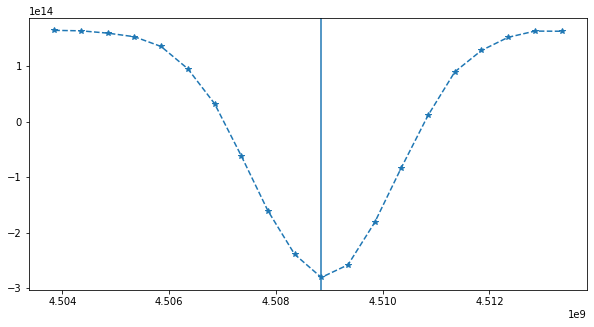

In [25]:
plt.figure(figsize=(10,5))
for i in range(len(qubit_spec_codes)):
    plt.plot(frequencies_GHz, all_vals[i],"*--")
plt.axvline(center_frequency_Hz)

plt.show()

In [26]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright